In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
from jax import jit, grad
import jax.numpy as jnp
from math import prod
import matplotlib.pyplot as plt

import jax
import optax
import functools

# 1 - Layer compilation

In [3]:
reg = jqtc.Register([2,4,3])
cirq = jqtc.Circuit.create(reg, layers=[])

X = jqtc.Gate.create(
    2, 
    name="X",
    gen_U = lambda params: jqtc.sigmax(),
    num_modes=1
)

D = jqtc.Gate.create(
    3, 
    name="D",
    params={"alpha": 1},
    gen_U = lambda params: jqtc.displace(3,params["alpha"]),
    num_modes=1
)

op_X = jqtc.Operation.create(X, 0, reg)
op_D = jqtc.Operation.create(D, 2, reg)

layer = jqtc.Layer.create([op_D, op_X])

layer

Layer(operations=[Operation(gate=D, indices=[2], register=Register(dims=[2, 4, 3])), Operation(gate=X, indices=[0], register=Register(dims=[2, 4, 3]))], _unique_indices=[0, 2], _default_simulate_mode=<SimulateMode.UNITARY: 'unitary'>)

In [4]:
U = layer.gen_U()

In [5]:
(U - (jqt.sigmax() ^ jqt.identity(4) ^ jqt.displace(3,1))).abs().max()

Array(0.+0.j, dtype=complex128)

# 2 - Simulating a Circuit

In [6]:
reg = jqtc.Register([2,4,3])
cirq = jqtc.Circuit.create(reg, layers=[])

X = jqtc.Gate.create(
    2, 
    name="X",
    gen_U = lambda params: jqtc.sigmax(),
    num_modes=1
)

D = jqtc.Gate.create(
    3, 
    name="D",
    gen_U = lambda params: jqtc.displace(3,1),
    num_modes=1
)

op_X = jqtc.Operation.create(X, 0, reg)
op_D = jqtc.Operation.create(D, 2, reg)

layer1 = jqtc.Layer.create([op_X, op_D])

Z = jqtc.Gate.create(
    2, 
    name="Z",
    gen_U = lambda params: jqtc.sigmaz(),
    num_modes=1
)

op_Z = jqtc.Operation.create(Z, 0, reg)

layer2 = jqtc.Layer.create([op_Z])

cirq.append_layer(layer1)
cirq.append_layer(layer2)

In [7]:
initial_state = (jqt.basis(2,0) + jqt.basis(2,1)) ^ jqt.basis(4,0) ^ jqt.basis(3,0)
initial_state = initial_state.unit()
res = jqtc.simulate(cirq, initial_state)

In [8]:
plusstate = (jqt.basis(2,0) -jqt.basis(2,1)).unit()

jqt.ptrace(res.results[2][0], 0) - plusstate.to_dm()

Quantum array: dims = ((2,), (2,)), bdims = (), shape = (2, 2), type = oper
Qarray data =
[[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

# 3 - Simpler circuit writing

## 3.1 - Simulation Options

In [9]:
N = 10
beta = 2
reg = jqtc.Register([2,N])
cirq = jqtc.Circuit.create(reg, layers=[])
cirq.append(jqtc.X(),0)
cirq.append(jqtc.CD(N, beta),[0,1])

Text(35.94444444444453, 0.5, 'Im[α]')

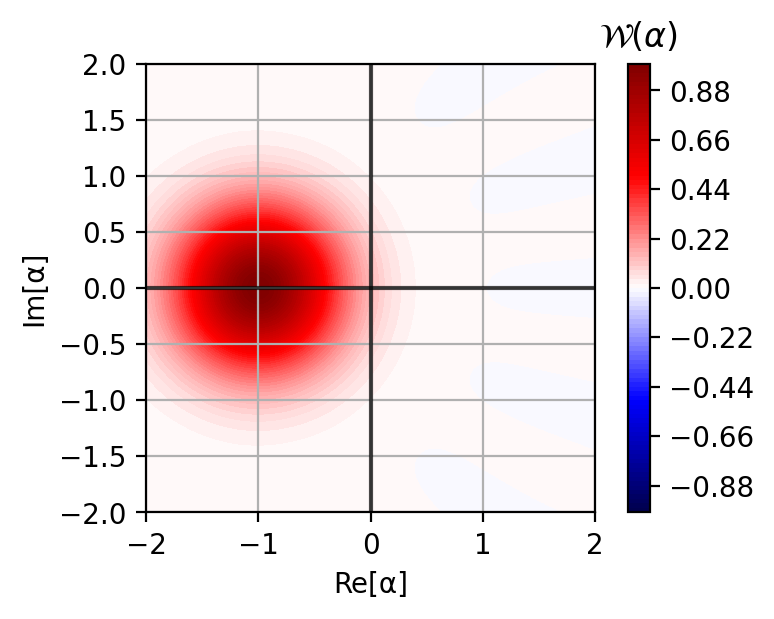

In [13]:
initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
res = jqtc.simulate(cirq, initial_state)

pts = jnp.linspace(-2,2, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(res[-1][-1],1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

Text(35.94444444444453, 0.5, 'Im[α]')

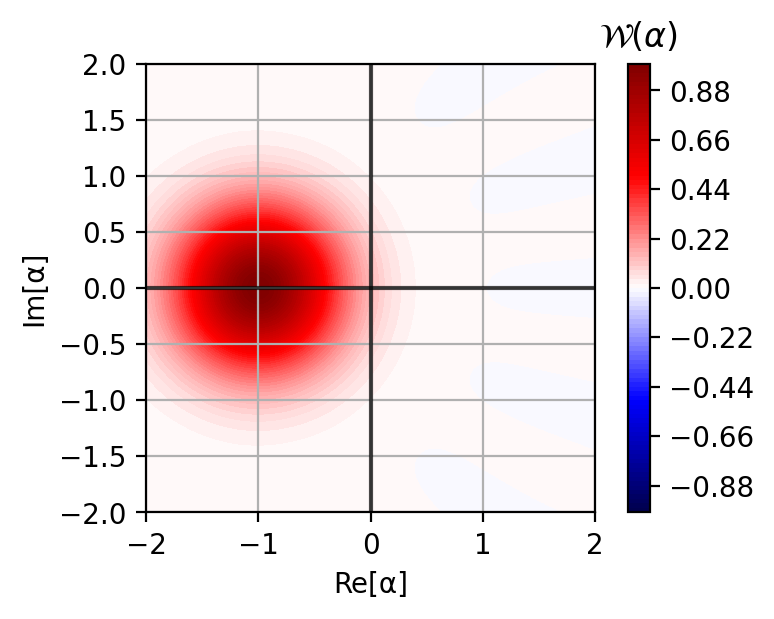

In [16]:
# start with a dm instead

initial_state = jqt.ket2dm(jqt.basis(2,0) ^ jqt.basis(N,0))
res = jqtc.simulate(cirq, initial_state)

pts = jnp.linspace(-2,2, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(res[-1][-1],1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

In [17]:
# start with a dm instead

initial_state = jqt.ket2dm(jqt.basis(2,0) ^ jqt.basis(N,0))
res = jqtc.simulate(cirq, initial_state, mode="kraus")

pts = jnp.linspace(-2,2, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(res[-1][-1],1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

NotImplementedError: Method collapse does not exist. No backup method found in [<module 'jax.numpy' from '/opt/miniconda3/envs/jax-framework/lib/python3.9/site-packages/jax/numpy/__init__.py'>, <module 'jax.numpy.linalg' from '/opt/miniconda3/envs/jax-framework/lib/python3.9/site-packages/jax/numpy/linalg.py'>, <module 'jax.scipy' from '/opt/miniconda3/envs/jax-framework/lib/python3.9/site-packages/jax/scipy/__init__.py'>, <module 'jax.scipy.linalg' from '/opt/miniconda3/envs/jax-framework/lib/python3.9/site-packages/jax/scipy/linalg.py'>].

## 3.2 - Measurement

In [13]:
reg = jqtc.Register([2])
cirq = jqtc.Circuit.create(reg, layers=[])
cirq.append(jqtc.H(),0)
cirq.append(jqtc.MZ(), 0)

In [14]:
initial_state = jqt.ket2dm(jqt.basis(2,0))
res = jqtc.simulate(cirq, initial_state, mode="kraus")

In [15]:
res

[Array of quantum arrays with: dims = [[2], [2]], shape = (1, 2, 2), type = oper
QarrayArray data =
[[[1.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]], Array of quantum arrays with: dims = [[2], [2]], shape = (1, 2, 2), type = oper
QarrayArray data =
[[[0.5+0.j 0.5+0.j]
  [0.5+0.j 0.5+0.j]]], Array of quantum arrays with: dims = [[2], [2]], shape = (1, 2, 2), type = oper
QarrayArray data =
[[[0.5+0.j 0. +0.j]
  [0. +0.j 0.5+0.j]]]]

# 4 - optimize

### 4a - Cost Function

In [16]:
@jit
def metric(beta):
    beta = beta[0]
    N = 10
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])
    cirq.append(jqtc.X(),0)
    cirq.append(jqtc.CD(N, beta),[0,1])
    
    initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
    res = jqtc.simulate(cirq, initial_state)

    final_state = res[-1][-1]
    target_state = jqt.basis(2,1) ^ (jqt.displace(N, -1.5) @ jqt.basis(N,0))
    return 1 - jnp.real((final_state.dag() @ target_state).data[0][0])
    
metric_grad = grad(metric)

In [17]:
metric(jnp.array([0.5])), metric_grad(jnp.array([0.5]))

(Array(0.54216664, dtype=float64), Array([-0.28614585], dtype=float64))

Following this guide: https://github.com/google-deepmind/optax/blob/main/docs/getting_started.ipynb

### 4b - Adam Optimizer 

In [18]:
start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

# Initialize parameters of the model + optimizer.
params = jnp.array([0.5])
opt_state = optimizer.init(params)

In [19]:
# A simple update loop.
params_history = [params[0]]
for _ in range(1000):
  grads = metric_grad(params)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  params_history.append(params[0])

params_history = jnp.array(params_history)

In [1]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(3,2))
ax.plot(params_history)
ax.axhline(3, ls="--", color="black", label="optimal")
ax.set_xlabel("Optimization Step")
ax.set_ylabel("Parameter Value")
ax.legend()

NameError: name 'plt' is not defined

### 4c - custom optimizer

In [21]:

# Exponential decay of the learning rate.
scheduler = optax.exponential_decay(
    init_value=start_learning_rate,
    transition_steps=1000,
    decay_rate=0.99)

# Combining gradient transforms using `optax.chain`.
gradient_transform = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

In [22]:
# Initialize parameters of the model + optimizer.
params = jnp.array([0.5])  # Recall target_params=0.5.
opt_state = gradient_transform.init(params)

# A simple update loop.
params_history = [params[0]]
for _ in range(1000):
  grads = metric_grad(params)
  updates, opt_state = gradient_transform.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  params_history.append(params[0])

params_history = jnp.array(params_history)

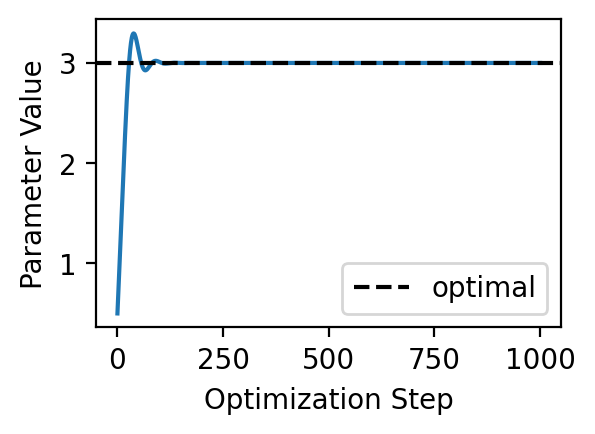

In [23]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(3,2))
ax.plot(params_history)
ax.axhline(3, ls="--", color="black", label="optimal")
ax.set_xlabel("Optimization Step")
ax.set_ylabel("Parameter Value")
ax.legend()